In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

!unzip -u /content/gdrive/MyDrive/feathersv1-dataset-master.zip #ryuno's so change if its different

#!unzip -u /content/gdrive/MyDrive/Colab\ Notebooks/DL\ Final\ Project/feathersv1-dataset-master.zip #Logan's

Streaming output truncated to the last 5000 lines.
   creating: feathersv1-dataset-master/images/passeriformes/saxicola_rubicola/
  inflating: feathersv1-dataset-master/images/passeriformes/saxicola_rubicola/passeriformes_saxicola_rubicola_00000.jpg  
  inflating: feathersv1-dataset-master/images/passeriformes/saxicola_rubicola/passeriformes_saxicola_rubicola_00001.jpg  
  inflating: feathersv1-dataset-master/images/passeriformes/saxicola_rubicola/passeriformes_saxicola_rubicola_00002.jpg  
  inflating: feathersv1-dataset-master/images/passeriformes/saxicola_rubicola/passeriformes_saxicola_rubicola_00003.jpg  
  inflating: feathersv1-dataset-master/images/passeriformes/saxicola_rubicola/passeriformes_saxicola_rubicola_00004.jpg  
  inflating: feathersv1-dataset-master/images/passeriformes/saxicola_rubicola/passeriformes_saxicola_rubicola_00005.jpg  
  inflating: feathersv1-dataset-master/images/passeriformes/saxicola_rubicola/passeriformes_saxicola_rubicola_00006.jpg  
  inflating: fea

In [ ]:
import os

## External Libraries
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as functional
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from skimage import io
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import LabelEncoder
from torchvision.transforms.functional import to_tensor
from sklearn.model_selection import train_test_split

data_dir = "./feathersv1-dataset-master"

DATA_SUBSET = 'top_100'

train_csv_path = f"{data_dir}/data/train_{DATA_SUBSET}_species.csv"
test_csv_path = f"{data_dir}/data/test_{DATA_SUBSET}_species.csv"

gpu_bool = torch.cuda.is_available()

def get_paths(csv_file, data_dir="./feathersv1-dataset-master/"):
    with open(csv_file, "r") as readfile:

        readfile.readline()  # skip header
        csv_data = readfile.readlines()

    image_paths = []
    for line in csv_data:
        path_parts = [x.lower().replace(" ", "_") for x in line.strip().split(",")]

        #data_dir/images/order_name/species_name/image_file_name
        image_path = (data_dir + '/images/' + path_parts[1] + '/' + path_parts[2] + '/' + path_parts[0]) 

        #append a string representation of the path
        image_paths.append(image_path)

    return image_paths

def get_labels(csv_path):
    # Return classes from CSV file.
    with open(csv_path, "r") as readfile:
        readfile.readline()  # skip header

        labels = []
        for line in readfile.readlines():
          split_line = line.strip().split(",")
          order = split_line[1]
          species = split_line[2]
          labels.append(order + '_' + species)

        le = LabelEncoder()
        le.fit(labels)
        int_labels = le.transform(labels)
        orig_labels = le.inverse_transform(int_labels)
        return int_labels

class FeatherDataset(Dataset):
    def __init__(self, image_paths, labels, transforms=[to_tensor]):

        self.image_paths = image_paths
        self.transforms = transforms
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = io.imread(img_path)

        for transform in self.transforms:
          img = transform(img)
        
        return img, label

train_transforms = [to_tensor, 
                    transforms.Resize((64,64)), 
                    transforms.RandomHorizontalFlip(0.5), 
                    transforms.RandomVerticalFlip(0.5),
                    transforms.ColorJitter(brightness=[0.8,1.2], contrast=[0.8,1.2], saturation=[0.8,1.2], hue=0)]

test_transforms = [to_tensor, transforms.Resize((64,64))]

X_train, X_val, y_train, y_val = train_test_split(get_paths(train_csv_path), get_labels(train_csv_path), train_size=0.8, shuffle=True, random_state=42)
train_dataset = FeatherDataset(X_train, y_train, transforms=train_transforms)
val_dataset = FeatherDataset(X_val, y_val, transforms=test_transforms)
test_dataset = FeatherDataset(get_paths(test_csv_path),  get_labels(test_csv_path), transforms=test_transforms)

train_batch_size = 32
test_batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

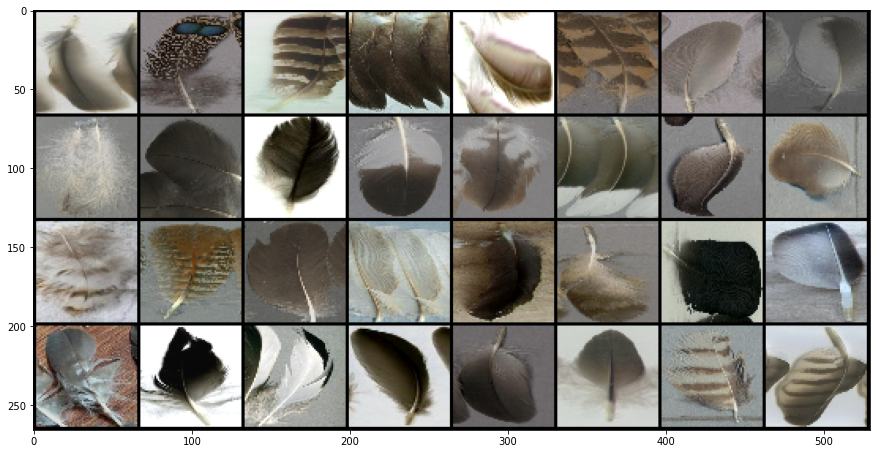

In [ ]:
batch = next(iter(train_dataloader))[0]
batch_grid = make_grid(batch, nrow=8)
plt.figure(figsize = (15,18))
plt.imshow(batch_grid.permute(1, 2, 0))
plt.show()

In [ ]:
print('We have ' + str(len(set(y_train))) + ' unique classes in the training set')
print('We have ' + str(len(set(y_val))) + ' unique classes in the validation set')
print('We have ' + str(len(set(get_labels(test_csv_path)))) + ' unique classes in the testing set\n')

print('Our training set contains ' + str(len(X_train)) + ' images')
print('Our validation set contains ' + str(len(X_val)) + ' images')
print('Out testing set contains ' + str(len(get_labels(test_csv_path))) + ' images\n')

class_instances_counts = {}

for label in y_train:
    if label in class_instances_counts:
        class_instances_counts[label] += 1
    else:
        class_instances_counts[label] = 1

print('Before data augmentation our most common class in the training set has ' + str(max(class_instances_counts.values())) + ' instances')
print('Before data augmentation our least common class has the training set has ' + str(min(class_instances_counts.values())) + ' instances')

We have 100 unique classes in the training set
We have 100 unique classes in the validation set
We have 100 unique classes in the testing set

Our training set contains 9562 images
Our validation set contains 2391 images
Out testing set contains 2988 images

Before data augmentation our most common class in the training set has 383 instances
Before data augmentation our least common class has the training set has 43 instances


In [ ]:
## Save Model
def saveModel(model, filename):
  model_save_name = filename
  path = F"/content/gdrive/My Drive/Colab Notebooks/DL Final Project/Models/{model_save_name}" 
  torch.save(model.state_dict(), path)

## Load Model
def loadModel(model, filename):
  model_save_name = filename
  path = F"/content/gdrive/My Drive/Colab Notebooks/DL Final Project/Models/{model_save_name}"
  trained_model = model
  trained_model.load_state_dict(torch.load(path))
  return trained_model

In [ ]:
def train_model(model, optimizer, loss_metric, filename, lr=0.001, num_epochs=5):

  if gpu_bool: model = model.cuda()

  train_loss_store = []
  train_acc_store = []
  val_loss_store = []
  val_acc_store = []
  val_loss = [1000000, 0]
  bestModel = model  # Keeping track of best model

  print("Start Training...")
  for epoch in range(num_epochs):
    model.train()
    time1 = time.time()

    train_total = 0
    train_correct = 0
    train_loss_sum = 0
    for i, (x,y) in enumerate(train_dataloader):
      if gpu_bool:
        x = x.cuda()
        y = y.cuda()
          #loss calculation and gradient update:
        if i > 0 or epoch > 0:
          optimizer.zero_grad()
        outputs = model.forward(x)
        loss = loss_metric.forward(outputs,y)
        loss.backward()
                      
          ##performing update:
        optimizer.step()
        loss = loss.detach()
        train_total += y.size(0)
        train_loss_sum += float(loss)
        predicted = torch.argmax(outputs, dim=1)
        train_correct += int((predicted.int() == y.int()).sum())
        del outputs
        del predicted
        del loss
        del x
        del y

    train_loss_store.append(train_loss_sum / train_total)
    train_acc_store.append((100 * (train_correct / train_total)))

    val_total = 0
    val_correct = 0
    val_loss_sum = 0

    model.eval()
    for i, (x,y) in enumerate(val_dataloader):
      if gpu_bool:
        x = x.cuda()
        y = y.cuda()

      outputs = model.forward(x)
      loss = loss_metric.forward(outputs,y)        
      loss = loss.detach()
      val_total += y.size(0)
      val_loss_sum += float(loss)

      predicted = torch.argmax(outputs, dim=1)
      val_correct += int((predicted.int() == y.int()).sum())
      del outputs
      del loss
      del x
      del y

      
    val_loss_store.append(float(val_loss_sum) / val_total)
    val_acc_store.append((100 * (val_correct / val_total)))


    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    time2 = time.time() #timekeeping
    print('Elapsed time for last epoch:',time2 - time1,'s')
    print('ETA of completion:', (time2 - time1)*(num_epochs - epoch - 1)/60,'minutes')
    print('Train Loss: ' + str(train_loss_store[-1]))
    print('Train Accuracy: ' + str(train_acc_store[-1]))
    print('Validation Loss: ' + str(val_loss_store[-1]))
    print('Validation Accuracy: ' + str(val_acc_store[-1]))
    if val_loss_store[-1] < val_loss[0]:
      val_loss[0] = val_loss_store[-1]
      val_loss[1] = 0
      bestModel = model
      saveModel(bestModel, filename)
    else:
      val_loss[1] += 1
      if val_loss[1] > 11:
        return bestModel, train_loss_store, train_acc_store, val_loss_store, val_acc_store

  return bestModel, train_loss_store, train_acc_store, val_loss_store, val_acc_store


In [ ]:
def visualize_metrics(train_loss, train_acc, val_loss, val_acc):

  ## Plotting sample-wise loss curve by epoch:
  plt.plot([i for i in range(1,len(train_loss)+1)], 
          train_loss, label = 'train_loss', color = 'blue')
  plt.plot([i for i in range(1, len(train_loss)+1)], 
          val_loss, label = 'validation_loss', color = 'orange')
  plt.title('Plot of Sample-Wise Loss by Epoch')
  plt.ylabel('Sample-Wise Loss At Epoch')
  plt.xlabel('Epoch Number')
  plt.legend()
  plt.show()

  ## Plotting sample-wise acc curve by epoch:
  plt.plot([i for i in range(1,len(train_acc)+1)], 
          train_acc, label = 'train_loss', color = 'blue')
  plt.plot([i for i in range(1, len(train_acc)+1)], 
          val_acc, label = 'validation_loss', color = 'orange')
  plt.title('Plot of Accuracy by Epoch')
  plt.ylabel('Accuracy At Epoch')
  plt.xlabel('Epoch Number')
  plt.legend()
  plt.show()

In [ ]:
def evaluate_model(model):
  print("Start Evaluating...")
  model.eval()
  test_total = 0
  test_correct = 0
  test_correct_5 = 0



  correct_arr = [0 for i in range(100)]
  total_arr = [0 for i in range(100)]

  for i, (x,y) in enumerate(test_dataloader):
    if gpu_bool:
      x = x.cuda()
      y = y.cuda()

    outputs = model.forward(x)
    test_total += y.size(0)
    predicted = torch.argmax(outputs, dim=1)
    _, predicted_5 = torch.topk(outputs, k=5, dim=1)
    test_correct += (predicted.int() == y.int()).sum()
    for i,x in enumerate(predicted_5):
      test_correct_5 += (y.int()[i] in x)

    for i, pred in enumerate(predicted.int()):
      total_arr[y.int()[i]] += 1
      correct_arr[y.int()[i]] += y.int()[i] == pred
  acc_arr = [i.cpu().item() / j for i, j in zip(correct_arr, total_arr)]

  print('Testing Accuracy: ' + str((100 * (test_correct / test_total)).item()))
  print('Top 5 Testing Accuracy: ' + str((100 * (test_correct_5 / test_total))))
  return acc_arr 

In [ ]:
from torchvision.models import vgg16
from sklearn.utils.class_weight import compute_class_weight

model = vgg16()
out = len(set(y_train))

print(out)
# modify task head
model._modules['classifier'][6] = nn.Linear(in_features=4096, 
                                            out_features=out, 
                                            bias=True)
num_epochs = 1000
learning_rate = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

class_weights = torch.tensor((compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)), dtype=torch.float)
if gpu_bool: class_weights = class_weights.cuda()
loss_metric = nn.CrossEntropyLoss(weight=torch.tensor(class_weights))

100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
trained_model, train_loss, train_acc, val_loss, val_acc = train_model(model, optimizer, loss_metric, "final_baseline_vgg.pt", lr=learning_rate, num_epochs=num_epochs)

Start Training...

EPOCH 1 of 1000

Elapsed time for last epoch: 93.58409690856934 s
ETA of completion: 1558.1752135276795 minutes
Train Loss: 0.14400613484984037
Train Accuracy: 1.390922401171303
Validation Loss: 0.14438472218914344
Validation Accuracy: 2.132998745294856

EPOCH 2 of 1000

Elapsed time for last epoch: 94.15231013298035 s
ETA of completion: 1566.0667585452397 minutes
Train Loss: 0.14328586723584558
Train Accuracy: 1.7360384856724536
Validation Loss: 0.14222159638957269
Validation Accuracy: 1.589293182768716

EPOCH 3 of 1000

Elapsed time for last epoch: 93.5975923538208 s
ETA of completion: 1555.279992945989 minutes
Train Loss: 0.13902458973046602
Train Accuracy: 2.5726835390085756
Validation Loss: 0.1329715874144244
Validation Accuracy: 4.182350480970305

EPOCH 4 of 1000

Elapsed time for last epoch: 93.68106198310852 s
ETA of completion: 1555.1056289196015 minutes
Train Loss: 0.13252171221399775
Train Accuracy: 4.361012340514537
Validation Loss: 0.12853436258635925
Va

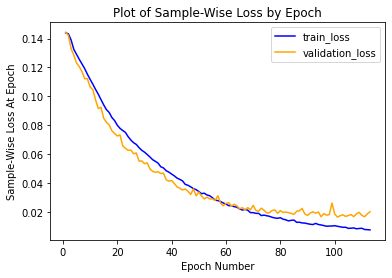

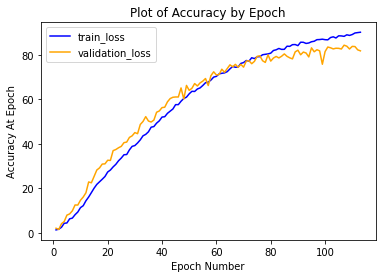

In [ ]:
visualize_metrics(train_loss, train_acc, val_loss, val_acc)

Start Evaluating...
Testing Accuracy: 82.89826202392578
Top 5 Testing Accuracy: 97.65729585006694


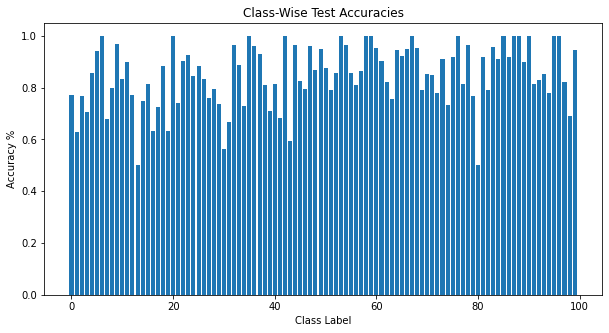

In [ ]:
acc_arr = evaluate_model(trained_model)

plt.rcParams["figure.figsize"] = (10,5)
plt.title('Class-Wise Test Accuracies')
plt.ylabel('Accuracy %')
plt.xlabel('Class Label')
plt.bar(range(100), acc_arr)
plt.show()

In [ ]:
class BNN_matmul(nn.Module):
    
    """
    
    """
    def __init__(self, n_classes):

        super(BNN_matmul, self).__init__()
        
        self.n_classes = n_classes

        # Downgrade stages
        self.VGGa = vgg16(pretrained = False).features
        # for element in self.VGGa.parameters():
        #   element.requires_grad = False
        self.VGGb = vgg16(pretrained = False).features
        self.reduction = nn.Conv2d(512, 160,  kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))

        # for element in self.VGGa.parameters():
        #   element.requires_grad = False

        self.classifier = vgg16().classifier[3:]

        self.classifier[0] =  nn.Linear(in_features=160*160, 
                                        out_features=4096, 
                                        bias=True)
        self.classifier[-1] = nn.Linear(in_features=4096, 
                                        out_features=self.n_classes, 
                                        bias=True)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        """
        Forward pass
        """
        outa = self.reduction(self.VGGa(x))
        outb = self.reduction(self.VGGb(x))
        outa_reshape = outa.reshape([outa.shape[0], outa.shape[1], -1])
        outb_reshape = outb.reshape([outb.shape[0], outb.shape[1], -1])
        outb_transpose = torch.permute(outb_reshape, (0,2,1))
        combo = torch.bmm(outa_reshape, outb_transpose) / (outa_reshape.shape[2]*2) # this should be an outer product, did they mean kroenecker product ???????
        combo_reshape = combo.reshape([combo.shape[0], -1])
        x = torch.nn.functional.normalize(torch.sign(combo_reshape) * torch.sqrt(torch.abs(combo_reshape) + 1e-10))
        unormalized_scores = self.classifier(x)
        normed_scores = unormalized_scores
        return normed_scores


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
model_bnn = BNN_matmul(100)

def init_weights(m):
  if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
    nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

model.apply(init_weights)

num_epochs = 1000
learning_rate = .000001  # was .000025 up to epoch ~40, reaching loss of .025 and val acc 78.5%
optimizer = torch.optim.Adam(model_bnn.parameters(), lr=learning_rate)

class_weights = torch.tensor((compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)), dtype=torch.float)
if gpu_bool: class_weights = class_weights.cuda()
loss_metric = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
# model_bnn = loadModel(model_bnn, "bnn_matmul_64_best_retry.pt")
trained_model_bnn, train_loss_bnn, train_acc_bnn, val_loss_bnn, val_acc_bnn = train_model(model_bnn, optimizer, loss_metric, "bnn_matmul_64_best_retry.pt", lr=learning_rate, num_epochs=num_epochs)

Start Training...

EPOCH 1 of 1000

Elapsed time for last epoch: 100.4018075466156 s
ETA of completion: 1671.6900956511497 minutes
Train Loss: 0.005273770375375567
Train Accuracy: 94.08073624764694
Validation Loss: 0.022331481695873175
Validation Accuracy: 80.46842325386866

EPOCH 2 of 1000

Elapsed time for last epoch: 101.17375373840332 s
ETA of completion: 1682.856770515442 minutes
Train Loss: 0.00481426252585541
Train Accuracy: 94.5513490901485
Validation Loss: 0.02150652341666156
Validation Accuracy: 81.59765788373066

EPOCH 3 of 1000

Elapsed time for last epoch: 100.62327313423157 s
ETA of completion: 1672.0233885804812 minutes
Train Loss: 0.004530134791797784
Train Accuracy: 95.12654256431709
Validation Loss: 0.021661630120799913
Validation Accuracy: 81.55583437892095

EPOCH 4 of 1000

Elapsed time for last epoch: 99.82976412773132 s
ETA of completion: 1657.1740845203399 minutes
Train Loss: 0.004253905584431423
Train Accuracy: 95.75402635431918
Validation Loss: 0.02169714727844

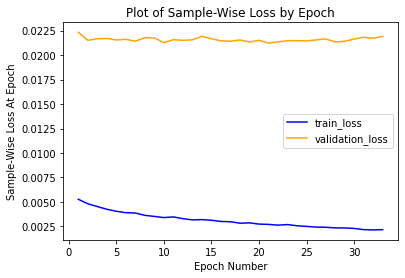

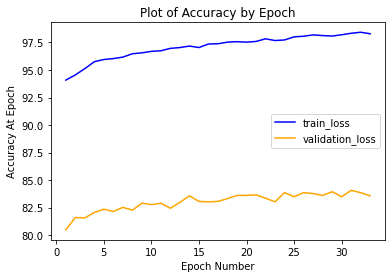

In [ ]:
visualize_metrics(train_loss_bnn, train_acc_bnn, val_loss_bnn, val_acc_bnn)

In [ ]:
evaluate_model(trained_model_bnn)

Start Evaluating...
Testing Accuracy: 84.53814697265625
Top 5 Testing Accuracy: 95.9170013386881


[0.8863636363636364,
 0.71900826446281,
 0.7666666666666667,
 0.7647058823529411,
 1.0,
 0.8235294117647058,
 0.9090909090909091,
 0.8214285714285714,
 0.8166666666666667,
 0.9117647058823529,
 0.8333333333333334,
 0.9183673469387755,
 0.7954545454545454,
 0.75,
 0.8125,
 0.813953488372093,
 0.6333333333333333,
 0.7272727272727273,
 0.7058823529411765,
 0.8947368421052632,
 0.9285714285714286,
 0.8260869565217391,
 0.8571428571428571,
 0.8888888888888888,
 0.6153846153846154,
 0.9230769230769231,
 0.7777777777777778,
 0.7380952380952381,
 0.896551724137931,
 0.5789473684210527,
 0.75,
 0.7333333333333333,
 0.8928571428571429,
 0.8333333333333334,
 0.8108108108108109,
 1.0,
 0.8846153846153846,
 0.9285714285714286,
 0.7142857142857143,
 0.8387096774193549,
 0.7777777777777778,
 0.7894736842105263,
 0.8823529411764706,
 0.776595744680851,
 0.9642857142857143,
 0.8260869565217391,
 0.8620689655172413,
 0.9615384615384616,
 0.9565217391304348,
 0.925,
 0.8333333333333334,
 0.79166666666666

# Custom Hierarchical Architecture

In [ ]:
# For these to work, make sure to right click our shared folder "DL Final Project" and select "Add shortcut to Drive"

## Save Model
def saveModel(model, filename):
  model_save_name = filename
  path = F"/content/gdrive/My Drive/{model_save_name}" 
  torch.save(model.state_dict(), path)

## Load Model
def loadModel(model, filename):
  model_save_name = filename
  path = F"/content/gdrive/My Drive/{model_save_name}"
  trained_model = model
  trained_model.load_state_dict(torch.load(path))
  return trained_model

In [ ]:
import os

## External Libraries
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as functional
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from skimage import io
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import LabelEncoder
from torchvision.transforms.functional import to_tensor
from sklearn.model_selection import train_test_split

data_dir = "./feathersv1-dataset-master"

DATA_SUBSET = 'top_100'

train_csv_path = f"{data_dir}/data/train_{DATA_SUBSET}_species.csv"
test_csv_path = f"{data_dir}/data/test_{DATA_SUBSET}_species.csv"

gpu_bool = torch.cuda.is_available()

def get_paths(csv_file, data_dir="./feathersv1-dataset-master/"):
    with open(csv_file, "r") as readfile:

        readfile.readline()  # skip header
        csv_data = readfile.readlines()

    image_paths = []
    for line in csv_data:
        path_parts = [x.lower().replace(" ", "_") for x in line.strip().split(",")]

        #data_dir/images/order_name/species_name/image_file_name
        image_path = (data_dir + '/images/' + path_parts[1] + '/' + path_parts[2] + '/' + path_parts[0]) 

        #append a string representation of the path
        image_paths.append(image_path)

    return image_paths

def get_labels(csv_path):
    # Return classes from CSV file.
    with open(csv_path, "r") as readfile:
        readfile.readline()  # skip header

        species_labels = []
        order_labels = []
        for line in readfile.readlines():
          split_line = line.strip().split(",")
          order = split_line[1]
          species = split_line[2]
          species_labels.append(species)
          order_labels.append(order)
        return species_labels, order_labels

train_labels = get_labels(train_csv_path)
test_labels = get_labels(test_csv_path)
train_labels_species = train_labels[0]
train_labels_order = train_labels[1]
test_labels_species = test_labels[0]
test_labels_order = test_labels[1]

les = LabelEncoder()
leo = LabelEncoder()
les.fit(list({*train_labels_species, *test_labels_species}))
leo.fit(list({*train_labels_order, *test_labels_order}))

enc_train_labels_species = les.transform(train_labels_species)
enc_test_labels_species = les.transform(test_labels_species)
enc_train_labels_order = leo.transform(train_labels_order)
enc_test_labels_order = leo.transform(test_labels_order)

#train_labels = [(x, y) for x, y in zip(enc_train_labels_order, enc_train_labels_species)]
#test_labels = [(x, y) for x, y in zip(enc_test_labels_order, enc_test_labels_species)]

class FeatherDataset(Dataset):
    def __init__(self, image_paths, labels, transforms=[to_tensor]):

        self.image_paths = image_paths
        self.transforms = transforms
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = io.imread(img_path)

        if img.shape[1] > img.shape[0]: img = np.swapaxes(img, 0, 1)

        for transform in self.transforms:
          img = transform(img)
        return img, label

train_image_paths = get_paths(train_csv_path)
test_image_paths = get_paths(test_csv_path)

train_transforms = [to_tensor, 
                    transforms.Resize((64,64)), 
                    transforms.RandomHorizontalFlip(0.5), 
                    transforms.RandomVerticalFlip(0.5),
                    transforms.ColorJitter(brightness=[0.8,1.2], contrast=[0.8,1.2], saturation=[0.8,1.2], hue=0)]

test_transforms = [to_tensor, transforms.Resize((64,64))]

X_train, X_val, y_train, y_val = train_test_split(train_image_paths, enc_train_labels_species, train_size=0.8, shuffle=True, random_state=42)
train_dataset = FeatherDataset(X_train, y_train, transforms=train_transforms)
val_dataset = FeatherDataset(X_val, y_val, transforms=test_transforms)
test_dataset = FeatherDataset(test_image_paths,  enc_test_labels_species, transforms=test_transforms)

train_batch_size = 32
test_batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [ ]:
train_labels = [(x, y) for x, y in zip(enc_train_labels_order, enc_train_labels_species)]
test_labels = [(x, y) for x, y in zip(enc_test_labels_order, enc_test_labels_species)]

train_image_paths = get_paths(train_csv_path)
test_image_paths = get_paths(test_csv_path)

train_transforms = [to_tensor, 
                    transforms.Resize((64,64)), 
                    transforms.RandomHorizontalFlip(0.5), 
                    transforms.RandomVerticalFlip(0.5),
                    transforms.ColorJitter(brightness=[0.8,1.2], contrast=[0.8,1.2], saturation=[0.8,1.2], hue=0)]

test_transforms = [to_tensor, transforms.Resize((64,64))]

X_train, X_val, y_train, y_val = train_test_split(train_image_paths, train_labels, train_size=0.8, shuffle=True, random_state=42)
train_dataset = FeatherDataset(X_train, y_train, transforms=train_transforms)
val_dataset = FeatherDataset(X_val, y_val, transforms=test_transforms)
test_dataset = FeatherDataset(test_image_paths,  test_labels, transforms=test_transforms)

train_batch_size = 32
test_batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

order_y = [y[0] for y in y_train]
species_y = [y[1] for y in y_train]

o_class_weights = torch.tensor((compute_class_weight(class_weight = 'balanced', classes = np.unique(order_y), y = order_y)), dtype=torch.float)
s_class_weights = torch.tensor((compute_class_weight(class_weight = 'balanced', classes = np.unique(species_y), y = species_y)), dtype=torch.float)

if gpu_bool: 
  o_class_weights = o_class_weights.cuda(), 
  s_class_weights = s_class_weights.cuda()


In [ ]:
def train_model_custom(model, optimizer, oloss_metric, sloss_metric, closs_metric, filename, lr=0.001, num_epochs=5):

  if gpu_bool: model = model.cuda()

  train_loss_store = []
  train_acc_store = []
  val_loss_store = []
  val_acc_store = []
  val_loss = [1000000, 0]
  bestModel = model


  print("Start Training...")
  for epoch in range(num_epochs):

    torch.cuda.empty_cache()

    model.train()
    time1 = time.time()

    train_total = 0
    train_correct = 0
    train_loss_sum = 0
    for i, (x,y) in enumerate(train_dataloader):
      o = y[0]
      s = y[1]

      if gpu_bool:
        x = x.cuda()
        o = o.cuda()
        s = s.cuda()

      #loss calculation and gradient update:
      if i > 0 or epoch > 0:
        optimizer.zero_grad()
      oOut, sOut, pred = model.forward(x)
      oLoss = oloss_metric(oOut, o)
      sLoss = sloss_metric(sOut, s)
      cLoss = closs_metric(pred, s)
      loss = (oLoss + sLoss + cLoss)/3

      loss.backward()
                  
      ##performing update:
      optimizer.step()

      loss = loss.detach()
      train_total += s.size(0)
      train_loss_sum += float(cLoss)

      predicted = torch.argmax(pred, dim=1)
      train_correct += int((predicted.int() == s.int()).sum())
      del oOut
      del sOut
      del predicted
      del loss
      del x
      del o
      del s

    train_loss_store.append(train_loss_sum / train_total)
    train_acc_store.append((100 * (train_correct / train_total)))

    val_total = 0
    val_correct = 0
    val_loss_sum = 0

    model.eval()
    for i, (x,y) in enumerate(val_dataloader):

      o = y[0]
      s = y[1]

      if gpu_bool:
        x = x.cuda()
        o = o.cuda()
        s = s.cuda()

      #loss calculation and gradient update:
      if i > 0 or epoch > 0:
        optimizer.zero_grad()
      oOut, sOut, pred = model.forward(x)
      oLoss = oloss_metric(oOut, o)
      sLoss = sloss_metric(sOut, s)
      cLoss = closs_metric(pred, s)
      loss = oLoss + sLoss

      loss = loss.detach()
      val_total += s.size(0)
      val_loss_sum += float(cLoss)

      predicted = torch.argmax(pred, dim=1)
      val_correct += int((predicted.int() == s.int()).sum())
      del oOut
      del sOut
      del predicted
      del loss
      del x
      del o
      del s

    val_loss_store.append(float(val_loss_sum) / val_total)
    val_acc_store.append((100 * (val_correct / val_total)))

    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    time2 = time.time() #timekeeping
    print('Elapsed time for last epoch:',time2 - time1,'s')
    print('ETA of completion:',
          (time2 - time1)*(num_epochs - epoch - 1)/60,'minutes')
    print('Train Loss: ' + str(train_loss_store[-1]))
    print('Train Accuracy: ' + str(train_acc_store[-1]))
    print('Validation Loss: ' + str(val_loss_store[-1]))
    print('Validation Accuracy: ' + str(val_acc_store[-1]))
    if val_loss_store[-1] < val_loss[0]:
      val_loss[0] = val_loss_store[-1]
      val_loss[1] = 0
      bestModel = model
      saveModel(bestModel, filename)
    else:
      val_loss[1] += 1
      if val_loss[1] > 11:
        return bestModel, train_loss_store, train_acc_store, val_loss_store, val_acc_store

  return model, train_loss_store, train_acc_store, val_loss_store, val_acc_store

In [ ]:
from torchvision.models import vgg16

In [ ]:
class Custom_BNN(nn.Module):
  def __init__(self,num_classes):
    super(Custom_BNN,self).__init__()
    vggo = vgg16(pretrained = False)
    vggs = vgg16(pretrained = False)
    vggc = vgg16(pretrained = False)
    #Parsing VGG
    self.num_classes = num_classes
    self.ofeats = vggo.features
    self.opool = vggs.avgpool 
    self.sfeats = vggc.features
    self.spool = vggc.avgpool 

    #Orders classifier
    self.oclassifier = vggo.classifier
    self.oclassifier[0] = nn.Linear(25088, 4096, bias = True)
    self.oclassifier[-1] = nn.Linear(4096,16, bias = True)

    #Species Classifier
    self.sclassifier = vggs.classifier
    self.sclassifier[0] = nn.Linear(25088, 4096, bias = True)
    self.sclassifier[-1] = nn.Linear(4096,100, bias = True)

    #Outer product classifier
    self.cclassifier = vggc.classifier
    self.cclassifier[0] =  nn.Linear(in_features=160*160, 
                                        out_features=4096, 
                                        bias=True)
    self.cclassifier[-1] = nn.Linear(in_features=4096, 
                                        out_features=self.num_classes, 
                                        bias=True)
    
  

    self.reduction = nn.Conv2d(512, 160,  kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))


  def forward(self, x):
        """
        Forward pass
        """
        order_features = self.ofeats(x)
        species_features = self.sfeats(x)
        

        order_pool = self.opool(order_features)
        order_pool = order_pool.reshape(order_pool.shape[0], -1)

        species_pool = self.spool(species_features)
        species_pool = species_pool.reshape(species_pool.shape[0], -1)


        
        order_out = self.oclassifier(order_pool)
        species_out = self.sclassifier(species_pool)
        
        outa = self.reduction(order_features)
        outb = self.reduction(species_features)

        outa_reshape = outa.reshape([outa.shape[0], outa.shape[1], -1])
        outb_reshape = outb.reshape([outb.shape[0], outb.shape[1], -1])
        outb_transpose = torch.permute(outb_reshape, (0,2,1))
        combo = torch.bmm(outa_reshape, outb_transpose) / (outa_reshape.shape[2]*2) # this should be an outer product, did they mean kroenecker product ???????
        combo_reshape = combo.reshape([combo.shape[0], -1])
        x = torch.nn.functional.normalize(torch.sign(combo_reshape) * torch.sqrt(torch.abs(combo_reshape) + 1e-10))
        unormalized_scores = self.cclassifier(x)
        normed_scores = unormalized_scores

        return order_out, species_out, normed_scores

  

In [ ]:
model=Custom_BNN(100)

num_epochs = 1000
learning_rate = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)

def init_weights(m):
  if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
    nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

model.apply(init_weights)

loss_metric_order = nn.CrossEntropyLoss(o_class_weights[0])
loss_metric_species = nn.CrossEntropyLoss(weight=torch.tensor(s_class_weights))
loss_metric_combined = nn.CrossEntropyLoss(weight=torch.tensor(s_class_weights))

In [ ]:

trained_model, train_loss, train_acc, val_loss, val_acc = train_model_custom(model, optimizer, loss_metric_order, loss_metric_species, loss_metric_combined,  filename="Final_customBNN.pt", lr=learning_rate, num_epochs=num_epochs)


Start Training...

EPOCH 1 of 1000

Elapsed time for last epoch: 126.76270174980164 s
ETA of completion: 386.62624033689497 minutes
Train Loss: 0.14400085847364313
Train Accuracy: 1.328174022171094
Validation Loss: 0.14438269657851363
Validation Accuracy: 0.6691760769552488

EPOCH 2 of 1000

Elapsed time for last epoch: 126.00285601615906 s
ETA of completion: 382.2086632490158 minutes
Train Loss: 0.14350997072661478
Train Accuracy: 1.6314578540054383
Validation Loss: 0.1417116745901327
Validation Accuracy: 3.6804684232538687

EPOCH 3 of 1000

Elapsed time for last epoch: 121.25014781951904 s
ETA of completion: 365.77127925554913 minutes
Train Loss: 0.1410508574713376
Train Accuracy: 2.6040577285086806
Validation Loss: 0.1401224068546335
Validation Accuracy: 2.9276453366792135

EPOCH 4 of 1000

Elapsed time for last epoch: 121.728600025177 s
ETA of completion: 365.185800075531 minutes
Train Loss: 0.14040041423646807
Train Accuracy: 2.9910060656766366
Validation Loss: 0.13980855307585024

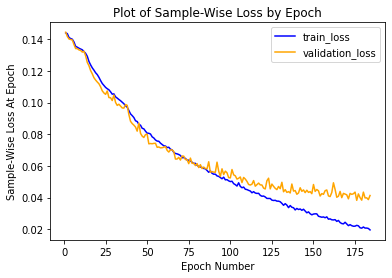

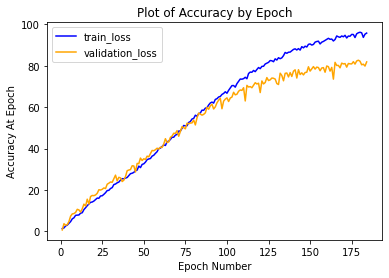

In [ ]:
visualize_metrics(train_loss, train_acc, val_loss, val_acc)


In [ ]:
def evaluate_model(model):
  print("Start Evaluating...")
  model.eval()
  test_total = 0
  test_correct = 0
  test_correct_5 = 0



  correct_arr = [0 for i in range(100)]
  total_arr = [0 for i in range(100)]

  for i, (x,y) in enumerate(test_dataloader):
    if gpu_bool:
      x = x.cuda()
      y = y[1].cuda()

    _,_,outputs = model.forward(x)
    test_total += y.size(0)
    predicted = torch.argmax(outputs, dim=1)
    _, predicted_5 = torch.topk(outputs, k=5, dim=1)
    test_correct += (predicted.int() == y.int()).sum()
    for i,x in enumerate(predicted_5):
      test_correct_5 += (y.int()[i] in x)

    for i, pred in enumerate(predicted.int()):
      total_arr[y.int()[i]] += 1
      correct_arr[y.int()[i]] += y.int()[i] == pred
  acc_arr = [i.cpu().item() / j for i, j in zip(correct_arr, total_arr)]

  print('Testing Accuracy: ' + str((100 * (test_correct / test_total)).item()))
  print('Top 5 Testing Accuracy: ' + str((100 * (test_correct_5 / test_total))))
  return acc_arr 

In [ ]:
acc_arr = evaluate_model(trained_model.cuda())

plt.rcParams["figure.figsize"] = (10,5)
plt.title('Class-Wise Test Accuracies')
plt.ylabel('Accuracy %')
plt.xlabel('Class Label')
plt.bar(range(100), acc_arr)
plt.show()

NameError: ignored

# Custom BNN 2

In [ ]:
class Custom_BNN2(nn.Module):
  def __init__(self,num_classes):
    super(Custom_BNN2, self).__init__()
    vggo = vgg16(pretrained = False)
    vggs = vgg16(pretrained = False)
    vggc = vgg16(pretrained = False)
    #Parsing VGG
    self.num_classes = num_classes
    self.ofeats1 = vggo.features[:15]
    self.ofeats2 = vggo.features[15:]
    self.opool = vggo.avgpool 
    self.sfeats1 = vggs.features[:15]
    self.sfeats2 = vggs.features[15:]
    self.spool = vggs.avgpool 

    #Orders classifier
    self.oclassifier = vggo.classifier
    self.oclassifier[0] = nn.Linear(25088, 4096, bias = True)
    self.oclassifier[-1] = nn.Linear(4096,16, bias = True)

    #Species Classifier
    self.sclassifier = vggs.classifier
    self.sclassifier[0] = nn.Linear(25088, 4096, bias = True)
    self.sclassifier[-1] = nn.Linear(4096,100, bias = True)

    #Outer product classifier
    self.cclassifier = vggc.classifier
    self.cclassifier[0] =  nn.Linear(in_features=160*160, 
                                        out_features=4096, 
                                        bias=True)
    self.cclassifier[-1] = nn.Linear(in_features=4096, 
                                        out_features=self.num_classes, 
                                        bias=True)
    
  

    self.reduction = nn.Conv2d(256, 160,  kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))



  def forward(self, x):
        """
        Forward pass
        """
        order_features1 = self.ofeats1(x)
        species_features1 = self.sfeats1(x)
        order_features2 = self.ofeats2(order_features1)
        species_features2 = self.sfeats2(species_features1)
        
        order_pool = self.opool(order_features2)
        order_pool = order_pool.reshape(order_pool.shape[0], -1)

        species_pool = self.spool(species_features2)
        species_pool = species_pool.reshape(species_pool.shape[0], -1)


        
        order_out = self.oclassifier(order_pool)
        species_out = self.sclassifier(species_pool)
        
        outa = self.reduction(order_features1)
        outb = self.reduction(species_features1)

        outa_reshape = outa.reshape([outa.shape[0], outa.shape[1], -1])
        outb_reshape = outb.reshape([outb.shape[0], outb.shape[1], -1])
        outb_transpose = torch.permute(outb_reshape, (0,2,1))
        combo = torch.bmm(outa_reshape, outb_transpose) / (outa_reshape.shape[2]*2) # this should be an outer product, did they mean kroenecker product ???????
        combo_reshape = combo.reshape([combo.shape[0], -1])
        x = torch.nn.functional.normalize(torch.sign(combo_reshape) * torch.sqrt(torch.abs(combo_reshape) + 1e-10))
        unormalized_scores = self.cclassifier(x)
        normed_scores = unormalized_scores

        return order_out, species_out, normed_scores


In [ ]:
model=Custom_BNN2(100)

num_epochs = 1000
learning_rate = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)

def init_weights(m):
  if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
    nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

model.apply(init_weights)

loss_metric_order = nn.CrossEntropyLoss(o_class_weights[0])
loss_metric_species = nn.CrossEntropyLoss(weight=s_class_weights)
loss_metric_combined = nn.CrossEntropyLoss(weight=s_class_weights)

In [ ]:
trained_model, train_loss, train_acc, val_loss, val_acc = train_model_custom(model, optimizer, loss_metric_order, loss_metric_species, loss_metric_combined,  filename="Final_custom_reduced_BNN2.pt", lr=learning_rate, num_epochs=num_epochs)

Start Training...

EPOCH 1 of 1000

Elapsed time for last epoch: 134.09461331367493 s
ETA of completion: 2232.6753116726877 minutes
Train Loss: 0.14402215552115585
Train Accuracy: 1.1399288851704663
Validation Loss: 0.14434830786442965
Validation Accuracy: 2.7185278126306986

EPOCH 2 of 1000

Elapsed time for last epoch: 137.32435250282288 s
ETA of completion: 2284.1617299636205 minutes
Train Loss: 0.14384701351220824
Train Accuracy: 1.589625601338632
Validation Loss: 0.14400164864642606
Validation Accuracy: 4.726056043496445

EPOCH 3 of 1000

Elapsed time for last epoch: 136.70719456672668 s
ETA of completion: 2271.617883050442 minutes
Train Loss: 0.14312096984534553
Train Accuracy: 3.126960886843756
Validation Loss: 0.1423787867260099
Validation Accuracy: 4.726056043496445

EPOCH 4 of 1000

Elapsed time for last epoch: 136.36116552352905 s
ETA of completion: 2263.5953476905825 minutes
Train Loss: 0.14046923083457158
Train Accuracy: 3.911315624346371
Validation Loss: 0.137534239061803

In [ ]:
def visualize_metrics(train_loss, train_acc, val_loss, val_acc):

  ## Plotting sample-wise loss curve by epoch:
  plt.plot([i for i in range(1,len(train_loss)+1)], 
          train_loss, label = 'train_loss', color = 'blue')
  plt.plot([i for i in range(1, len(train_loss)+1)], 
          val_loss, label = 'validation_loss', color = 'orange')
  plt.title('Plot of Sample-Wise Loss by Epoch')
  plt.ylabel('Sample-Wise Loss At Epoch')
  plt.xlabel('Epoch Number')
  plt.legend()
  plt.show()

  ## Plotting sample-wise acc curve by epoch:
  plt.plot([i for i in range(1,len(train_acc)+1)], 
          train_acc, label = 'train_loss', color = 'blue')
  plt.plot([i for i in range(1, len(train_acc)+1)], 
          val_acc, label = 'validation_loss', color = 'orange')
  plt.title('Plot of Accuracy by Epoch')
  plt.ylabel('Accuracy At Epoch')
  plt.xlabel('Epoch Number')
  plt.legend()
  plt.show()

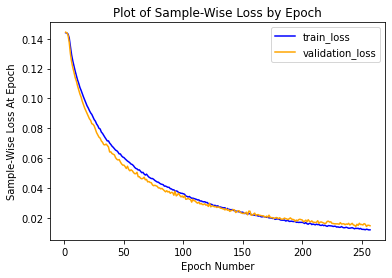

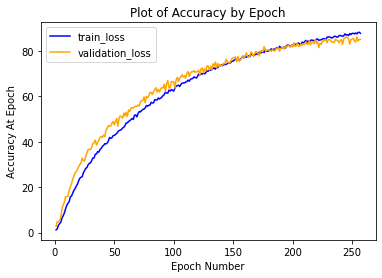

In [ ]:
visualize_metrics(train_loss, train_acc, val_loss, val_acc)

Start Evaluating...
Testing Accuracy: 85.74296569824219
Top 5 Testing Accuracy: 98.05890227576974


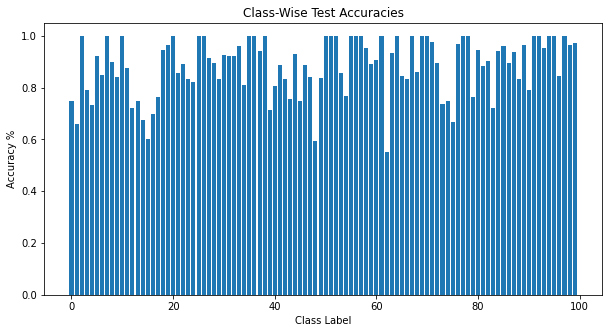

In [ ]:
acc_arr = evaluate_model(trained_model.cuda())

plt.rcParams["figure.figsize"] = (10,5)
plt.title('Class-Wise Test Accuracies')
plt.ylabel('Accuracy %')
plt.xlabel('Class Label')
plt.bar(range(100), acc_arr)
plt.show()

#Best BNN

In [ ]:
class BNN_matmul(nn.Module):
    
    """
    
    """
    def __init__(self, n_classes):

        super(BNN_matmul, self).__init__()
        
        self.n_classes = n_classes

        # Downgrade stages
        self.VGGa = vgg16(pretrained = False).features[:15]
        # for element in self.VGGa.parameters():
        #   element.requires_grad = False
        self.VGGb = vgg16(pretrained = False).features[:15]
        self.reduction = nn.Conv2d(256, 160,  kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))

        # for element in self.VGGa.parameters():
        #   element.requires_grad = False

        self.classifier = vgg16().classifier

        self.classifier[0] =  nn.Linear(in_features=160*160, 
                                        out_features=4096, 
                                        bias=True)
        self.classifier[-1] = nn.Linear(in_features=4096, 
                                        out_features=self.n_classes, 
                                        bias=True)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        """
        Forward pass
        """
        outa = self.reduction(self.VGGa(x))
        outb = self.reduction(self.VGGb(x))
        outa_reshape = outa.reshape([outa.shape[0], outa.shape[1], -1])
        outb_reshape = outb.reshape([outb.shape[0], outb.shape[1], -1])
        outb_transpose = torch.permute(outb_reshape, (0,2,1))
        combo = torch.bmm(outa_reshape, outb_transpose) / (outa_reshape.shape[2]*2) # this should be an outer product, did they mean kroenecker product ???????
        combo_reshape = combo.reshape([combo.shape[0], -1])
        x = torch.nn.functional.normalize(torch.sign(combo_reshape) * torch.sqrt(torch.abs(combo_reshape) + 1e-10))
        unormalized_scores = self.classifier(x)
        normed_scores = unormalized_scores
        return normed_scores

# Images Incorrectly Classified by VGG

In [ ]:
def loadFinalModel(model, filename):
  model_save_name = filename
  path = F"/content/gdrive/My Drive/DL Final Project/Models/Final Models/{model_save_name}"
  trained_model = model
  trained_model.load_state_dict(torch.load(path))
  return trained_model

In [ ]:
from torchvision.models import vgg16
from sklearn.utils.class_weight import compute_class_weight

model = vgg16()
out = len(set(y_train))

print(out)
# modify task head
model._modules['classifier'][6] = nn.Linear(in_features=4096, 
                                            out_features=out, 
                                            bias=True)

100


In [ ]:
vgg = loadFinalModel(model, 'final_baseline_vgg_init.pt')

Start Evaluating...
Testing Accuracy: 86.2784423828125
Top 5 Testing Accuracy: 97.85809906291834


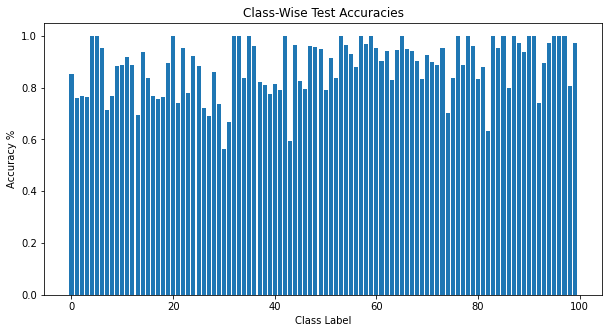

In [ ]:
acc_arr = evaluate_model(vgg.cuda())

plt.rcParams["figure.figsize"] = (10,5)
plt.title('Class-Wise Test Accuracies')
plt.ylabel('Accuracy %')
plt.xlabel('Class Label')
plt.bar(range(100), acc_arr)
plt.show()

In [ ]:
model_bnn = BNN_matmul(100)
bcnn = loadFinalModel(model_bnn, 'bnn_logan_test.pt')

Start Evaluating...
Testing Accuracy: 91.70013427734375
Top 5 Testing Accuracy: 99.09638554216868


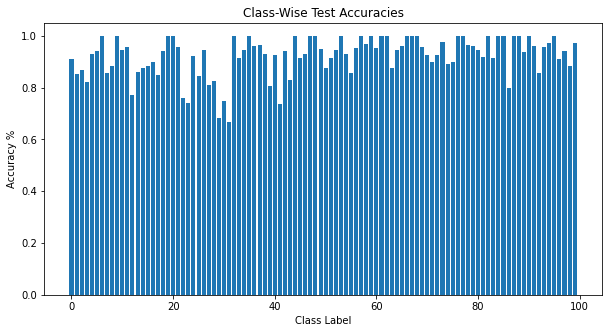

In [ ]:
acc_arr = evaluate_model(bcnn.cuda())

plt.rcParams["figure.figsize"] = (10,5)
plt.title('Class-Wise Test Accuracies')
plt.ylabel('Accuracy %')
plt.xlabel('Class Label')
plt.bar(range(100), acc_arr)
plt.show()

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

vgg.eval()
bcnn.eval()


vgg_array = []
bcnn_array = []

for i, (x,y) in enumerate(test_dataloader):
  if gpu_bool:
    x = x.cuda()
    y = y.cuda()

  vgg_outputs = vgg.forward(x)
  vgg_predicted = torch.argmax(vgg_outputs, dim=1)

  if vgg_predicted.int() == y.int():
    vgg_array.append((1,x))
  else: 
    vgg_array.append((0,x))

  bcnn_outputs = bcnn.forward(x)
  bcnn_predicted = torch.argmax(bcnn_outputs, dim=1)
    
  if bcnn_predicted.int() == y.int():
    bcnn_array.append((1,x))
  else: 
    bcnn_array.append((0,x))



   

In [ ]:
correct_bcnn_not_vgg = []
imgs = []
correct_vgg_not_bcnn = []
both_correct = []
both_incorrect = []


for i in range(len(bcnn_array)):
  out1 = vgg_array[i][0]
  out2 = bcnn_array[i][0]

  if out1 == 0 and out2 == 1: 
    correct_bcnn_not_vgg.append(i)
    imgs.append(vgg_array[i][1])
  elif out1 == 1 and out2 == 0: 
    correct_vgg_not_bcnn.append(i)

  elif out1 == 1 and out2 == 1: 
    both_correct.append(i)

  elif out1 == 0 and out2 == 0: 
    both_incorrect.append(i)
  


In [ ]:
for idx in correct_bcnn_not_vgg: 
  path = get_paths(test_csv_path)[idx]
  name = path.split('/')[-1]
  print(name)
  smp_img = io.imread(get_paths(test_csv_path)[idx])
  #plt.figure(smp_img)
  # plt.imshow(smp_img)
  # plt.show()
  io.imsave('/content/gdrive/MyDrive/DL Final Project/Sample Images/'+name, smp_img)

accipitriformes_accipiter_gentilis_00322.jpg
ciconiiformes_botaurus_stellaris_00018.jpg
accipitriformes_accipiter_gentilis_00432.jpg
charadriiformes_calidris_canutus_00107.jpg
accipitriformes_accipiter_nisus_00235.jpg
anseriformes_anas_platyrhynchos_00000.jpg
charadriiformes_haematopus_ostralegus_00168.jpg
passeriformes_aegithalos_caudatus_00056.jpg
piciformes_dendrocopos_major_00019.jpg
accipitriformes_aquila_nipalensis_00025.jpg
strigiformes_asio_flammeus_00135.jpg
passeriformes_garrulus_glandarius_00090.jpg
passeriformes_phylloscopus_collybita_00094.jpg
charadriiformes_larus_crassirostris_00116.jpg
charadriiformes_larus_cachinnans_00043.jpg
accipitriformes_accipiter_nisus_00467.jpg
passeriformes_phylloscopus_collybita_00097.jpg
charadriiformes_charadrius_dubius_00100.jpg
anseriformes_anas_platyrhynchos_00038.jpg
accipitriformes_circus_cyaneus_00165.jpg
accipitriformes_aquila_chrysaetos_00015.jpg
ciconiiformes_botaurus_stellaris_00024.jpg
charadriiformes_haematopus_ostralegus_00412.j